# Import

In [1]:
%matplotlib inline
import os
import matplotlib
import numpy as np
import pandas as pd
import sklearn.metrics
import matplotlib.cm as cmap
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# PCA
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Functions

Note that k-means knows nothing about the identity of the cluster, the 0-2 labels may be permuted. 

Hence the colors are not coherent among different plots

In [2]:
class Dataset:
    def __init__(self, data, target, target_names, data_pca=None, data_lda=None):
        self.data = data
        self.target = target
        self.target_names = target_names
        self.data_pca = data_pca
        self.data_lda = data_lda

# <u>Assignment</u> My Kmeans
Expectation–maximization (EM) is a powerful algorithm that comes up in a variety of contexts within data science. k-means is a simple and easy-to-understand application of EM

In short, the expectation–maximization approach here consists of the following procedure:

    Step 1. Guess some cluster centers
    Then, until convergence
        Step 2. (E-Step). Assign points to the nearest cluster center 
        Step 3. (M-Step). Set the cluster centers to the mean

Here the "E-step" or "Expectation step" involves updating the expectation of which cluster each point belongs to. 

The "M-step" or "Maximization step" involves maximizing some **fitness** function that defines the location of the cluster centers. In this case, the maximization is accomplished by taking a simple mean of the data in each cluster.

* For step 2 check [sklearn.metrics.pairwise_distances_argmin](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances_argmin.html)

* Convergence: the cluster centers  in the last two consequent iterations are same.

* Implement also the sum of the squared distances, that is:

    $I = \sum_{i}d(i,cr)$, where $i$ is a given sample, $cr$ is the centroid of the assigned cluster and $d$ is the squared distance
    
    This metric, equivalent to [inertia](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) in scikitlearn, will be exploited to find the best number of clusters
    
    Check [sklearn.metrics.pairwise_distances_argmin_min](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances_argmin_min.html) to implement the sum of the squared distances

In [3]:
# Import necessary packages
from sklearn.metrics import pairwise_distances_argmin, pairwise_distances_argmin_min

def find_clusters(X, n_clusters, rseed=2):
    # Step 1. Guess some cluster centers
    # A fixed seed and a fixed series of calls to ‘RandomState’ methods using the same parameters 
    # will always produce the same results.
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centroids = X[i]

    while True:
        # Step 2. Assign points to the nearest cluster center
        clusters = pairwise_distances_argmin(X, centroids)

        # Step 3. Set the cluster centers to the mean
        means = np.array([np.mean(X[clusters == i], axis=0) for i in range(n_clusters)])

        # Check for convergence: if convergence has been achieved, break the loop
        if np.all(centroids == means):
            break

        # Else, update centroids
        centroids = means

    # Sum of the squared distances (within clusters)
    ssd = np.sum(pairwise_distances_argmin_min(X, centroids)[1] ** 2)

    return centroids, clusters, ssd

# Iris dataset
![title](images/iris_petal_sepal.png)
In this first application you are going to work with the milestone [iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set), investigated yet in Numpy assignment

## Loading

In [4]:
from sklearn.datasets import load_iris

dataset = load_iris()
print(dataset['DESCR'])
print("Features shape: \n\t{}".format(dataset.data.shape))
print("Labels shape: \n\t{}".format(dataset.target.shape))

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

## Sklearn kmeans: effect of different random initialization
Although the EM procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the <u>global best solution</u>. 

What happens if we use a different random number generation for centroid initialization in [sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)?

See  [Pair confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cluster.pair_confusion_matrix.html) for comparing two clusters (in this case, the comparison term are the real labels).

<ipython-input-5-9c96ceceb4b2>:22: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[0].scatter(centers[:, 0], centers[:, 1],
<ipython-input-5-9c96ceceb4b2>:22: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[0].scatter(centers[:, 0], centers[:, 1],


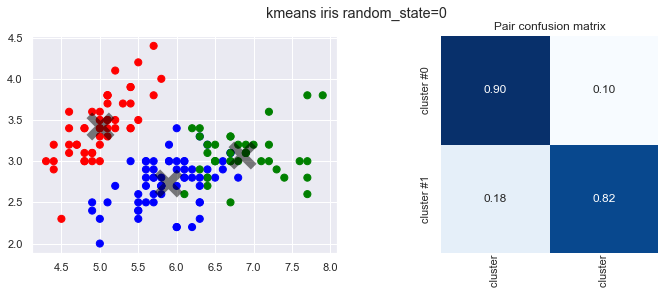

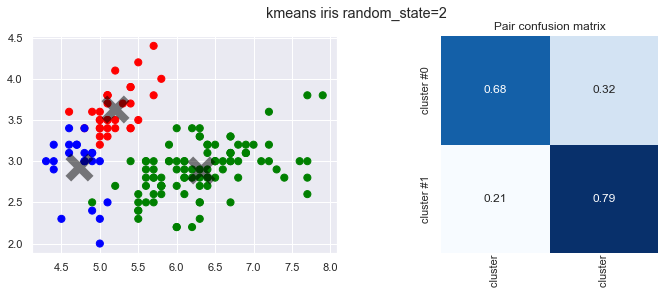

In [5]:
colors = ["red","green","blue"]
from sklearn.cluster import KMeans
n_cluster = 3

kmeans_0 = KMeans(n_clusters=n_cluster, random_state=0, n_init=1)
kmeans_1 = KMeans(n_clusters=n_cluster, random_state=2, n_init=1)
estimators = [("kmeans iris random_state=0", kmeans_0), 
              ("kmeans iris random_state=2", kmeans_1)]


X = dataset.data
for name, est in estimators:
    est.fit(X)
    y_kmeans = est.predict(X)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(name)
    ax[0].scatter(X[:, 0], X[:, 1], c=y_kmeans,
               s=50, cmap=matplotlib.colors.ListedColormap(colors))

    centers = est.cluster_centers_
    # Plot centroids
    ax[0].scatter(centers[:, 0], centers[:, 1], 
               c="black", 
               s=500, 
               alpha=0.5, 
               marker="x", 
               linewidths=8, 
               edgecolor="black",
               cmap=matplotlib.colors.ListedColormap(colors))
    
    # pair_confusion_matrix >>>>
    from sklearn.metrics.cluster import pair_confusion_matrix
    mat = pair_confusion_matrix(dataset.target, y_kmeans)
    cm = mat.astype("float") / mat.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, ax=ax[1], square=True, annot=True, cmap="Blues", fmt=".2f", cbar=False)
    ax[1].set_title("Pair confusion matrix")
    ax[1].set_yticklabels(["cluster #{}".format(c) for c in range(2)], rotation=90, va="center")
    ax[1].set_xticklabels(["cluster #{}".format(c) for c in range(2)], rotation=90, va="center")
    # <<<<

##  sklearn.cluster.KMeans: different runs of the k-means algorithm
[sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) by default runs n_init=10 times the k-means algorithm. The final results will be the best output of n_init consecutive runs in terms of inertia.

<ipython-input-6-0b27a13294c5>:21: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[0].scatter(centers[:, 0], centers[:, 1],
<ipython-input-6-0b27a13294c5>:21: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[0].scatter(centers[:, 0], centers[:, 1],


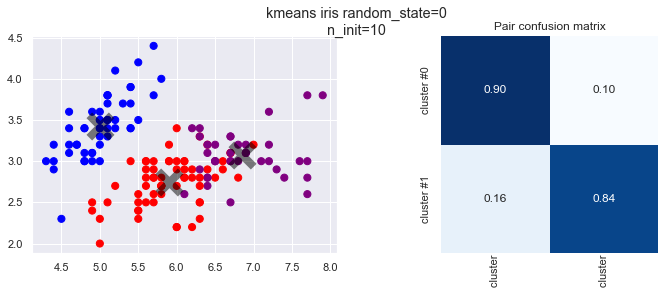

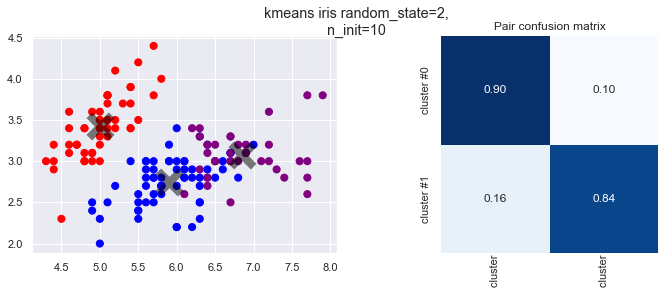

In [6]:
colors = ["red","green","blue","purple"]
from sklearn.cluster import KMeans
n_cluster = 3

kmeans_0 = KMeans(n_clusters=n_cluster, random_state=0, n_init=10)
kmeans_1 = KMeans(n_clusters=n_cluster, random_state=2, n_init=10)
estimators = [("kmeans iris random_state=0\nn_init=10", kmeans_0), 
              ("kmeans iris random_state=2,\nn_init=10", kmeans_1)]

X = dataset.data
for name, est in estimators:
    est.fit(X)
    y_kmeans = est.predict(X)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(name)
    ax[0].scatter(X[:, 0], X[:, 1], c=y_kmeans,
               s=50, cmap=matplotlib.colors.ListedColormap(colors))

    centers = est.cluster_centers_
    # Plot centroids
    ax[0].scatter(centers[:, 0], centers[:, 1], 
               c="black", 
               s=500, 
               alpha=0.5, 
               marker="x", 
               linewidths=8, 
               edgecolor="black",
               cmap=matplotlib.colors.ListedColormap(colors))
    
    # pair_confusion_matrix >>>>
    from sklearn.metrics.cluster import pair_confusion_matrix
    mat = pair_confusion_matrix(dataset.target, y_kmeans)
    cm = mat.astype("float") / mat.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, ax=ax[1], square=True, annot=True, cmap="Blues", fmt=".2f", cbar=False)
    ax[1].set_title("Pair confusion matrix")
    ax[1].set_yticklabels(["cluster #{}".format(c) for c in range(2)], rotation=90, va="center")
    ax[1].set_xticklabels(["cluster #{}".format(c) for c in range(2)], rotation=90, va="center")
    # <<<<

## Insight into features
We visualize the distributions of the four different features in 1-dimensional histograms.

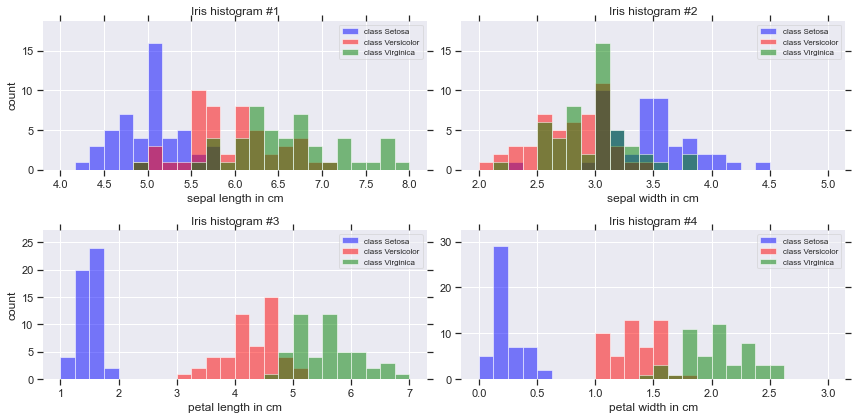

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
label_dict = {0: "Setosa", 1: "Versicolor", 2:"Virginica"}
feature_dict = {i:label for i,label in zip(
                range(4),
                  ("sepal length in cm",
                   "sepal width in cm",
                   "petal length in cm",
                   "petal width in cm", ))}

for ax, cnt in zip(axes.ravel(), range(4)):  

    # set bin sizes
    min_b = np.floor(np.min(X[:, cnt]))
    max_b = np.ceil(np.max(X[:, cnt]))
    bins = np.linspace(min_b, max_b, 25)

    # plottling the histograms
    for lab, col in zip(range(3), ("blue", "red", "green")):
        ax.hist(dataset.data[dataset.target==lab, cnt],
                color=col,
                label="class %s" %label_dict[lab],
                bins=bins,
                alpha=0.5,)
    ylims = ax.get_ylim()

    # plot annotation
    leg = ax.legend(loc="upper right", fancybox=True, fontsize=8)
    leg.get_frame().set_alpha(0.5)
    ax.set_ylim([0, max(ylims)+2])
    ax.set_xlabel(feature_dict[cnt])
    ax.set_title("Iris histogram #%s" %str(cnt+1))

    # hide axis ticks
    ax.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

axes[0][0].set_ylabel("count")
axes[1][0].set_ylabel("count")

fig.tight_layout()

Petal lengths and widths are likely better suited as potential features two separate between the three flower classes.

In practice, instead of reducing the dimensionality via a projection (here: LDA), a good alternative would be a feature selection technique (see in Lab3)

## Investigate the effect of PCA & LDA
LDA basics
![title](images/pca_vs_lda.png)

Both Linear Discriminant Analysis (LDA) and Principal Component Analysis (PCA) are linear transformation techniques that are commonly used for dimensionality reduction. PCA can be described as an “unsupervised” algorithm, since it “ignores” class labels and its goal is to find the directions (the so-called principal components) that maximize the variance in a dataset. In contrast to PCA, LDA is “supervised” and searches for those vectors in the underlying space that best discriminate among classes (rather than those that best describe the data). More
formally, given a number of independent features relative to which the data is described, LDA creates a linear combination of these which yields the largest mean differences between the desired classes.

LDA needs labels, hence is intrinsically in contrast with clustering techniques. Here we are going to borrow LDA from supervised classification just in view of looking at its effect on clustering, compared to PCA one.

For further reading:

    A. M. Martinez and A. C. Kak, "PCA versus LDA," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 23, no. 2, pp. 228-233, Feb. 2001, doi: 10.1109/34.908974.

It should also be mentioned that LDA assumes normal distributed data, features that are statistically independent, and identical covariance matrices for every class. However, this only applies for LDA as classifier and LDA for dimensionality reduction can also work reasonably well if those assumptions are violated. And even for classification tasks LDA seems can be quite robust to the distribution of the data:

    “linear discriminant analysis frequently achieves good performances in the tasks of face and object recognition, even though the assumptions of common covariance matrix among groups and normality are often violated (Duda, et al., 2001)” (Tao Li, et al., 2006).

<ipython-input-8-7f2bf8330718>:29: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[0].scatter(centers[:, 0], centers[:, 1],
<ipython-input-8-7f2bf8330718>:29: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[0].scatter(centers[:, 0], centers[:, 1],
<ipython-input-8-7f2bf8330718>:29: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[0].scatter(centers[:, 0], centers[:, 1],


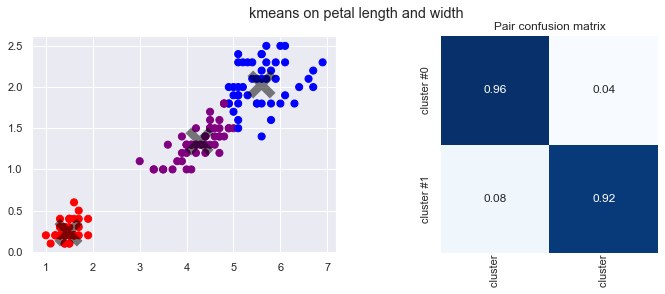

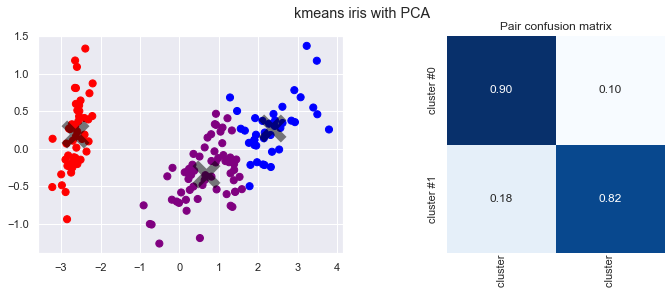

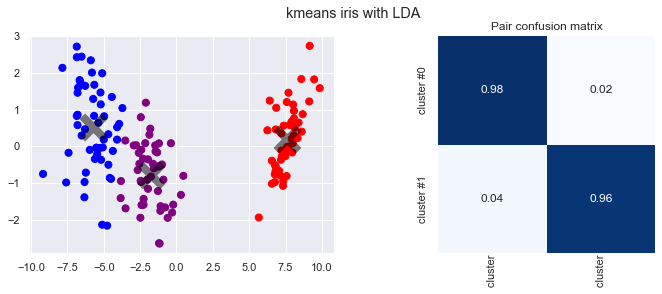

In [8]:
data_pca = PCA(n_components=3, svd_solver="full").fit_transform(dataset.data)
data_lda = LinearDiscriminantAnalysis(n_components=2).fit_transform(dataset.data, dataset.target)

colors = ["red","green","blue","purple"]
from sklearn.cluster import KMeans
n_cluster = 3

dataset = Dataset(dataset.data, dataset.target, dataset.target_names, data_pca, data_lda)

only_petal_features = dataset.data[:, 2:4]
kmeans = KMeans(n_clusters=n_cluster, random_state=0, n_init=1).fit(only_petal_features)
kmeans_pca = KMeans(n_clusters=n_cluster, random_state=0, n_init=1).fit(dataset.data_pca)
kmeans_lda = KMeans(n_clusters=n_cluster, random_state=0, n_init=1).fit(dataset.data_lda)
estimators = [
    ("kmeans on petal length and width", kmeans),
    ("kmeans iris with PCA", kmeans_pca), 
    ("kmeans iris with LDA", kmeans_lda)
]

for (name, est), data in zip(estimators, [only_petal_features, dataset.data_pca, dataset.data_lda]):
    y_kmeans = est.labels_
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(name)
    ax[0].scatter(data[:, 0], data[:, 1], c=y_kmeans,
               s=50, cmap=matplotlib.colors.ListedColormap(colors))

    centers = est.cluster_centers_
    # Plot centroids
    ax[0].scatter(centers[:, 0], centers[:, 1], 
               c="black", 
               s=500, 
               alpha=0.5, 
               marker="x", 
               linewidths=8, 
               edgecolor="black",
               cmap=matplotlib.colors.ListedColormap(colors))
    
    # pair_confusion_matrix >>>>
    from sklearn.metrics.cluster import pair_confusion_matrix
    mat = pair_confusion_matrix(dataset.target, y_kmeans)
    cm = mat.astype("float") / mat.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, ax=ax[1], square=True, annot=True, cmap="Blues", fmt=".2f", cbar=False)
    ax[1].set_title("Pair confusion matrix")
    ax[1].set_yticklabels(["cluster #{}".format(c) for c in range(2)], rotation=90, va="center")
    ax[1].set_xticklabels(["cluster #{}".format(c) for c in range(2)], rotation=90, va="center")
    # <<<<

## <u>Assignment</u> How many clusters (1)? Silhouette scores
The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.

See [sklearn.metrics.silhouette_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

* Plot a scatter plot showing the clusters for each k in n_clusters (that is different number of clusters passed to the kmeans)
* Compute silhouette scores for each sample (see [silhouette_samples](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html)) and create an histogram showing the distribution of silhouette scores for each k
* Compute the mean silhouette_score, which gives the average value for all the samples (see [silhouette_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)) 
and plot as red vertical line on histogram

Examples of plot for k=3
![title](images/silhouette.png)

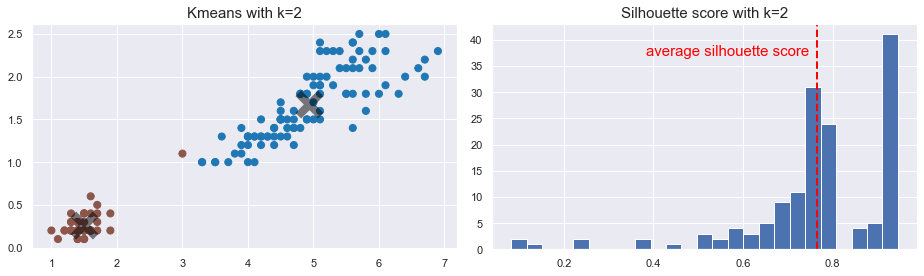

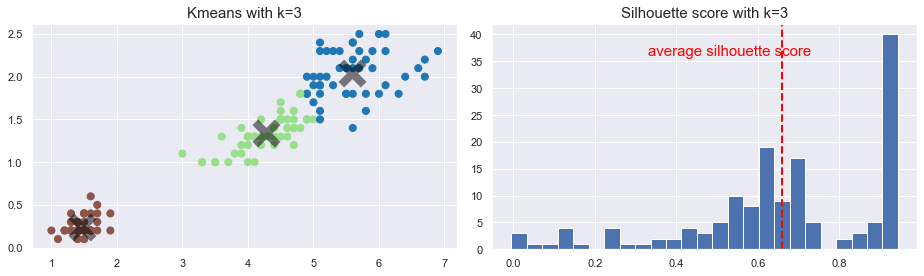

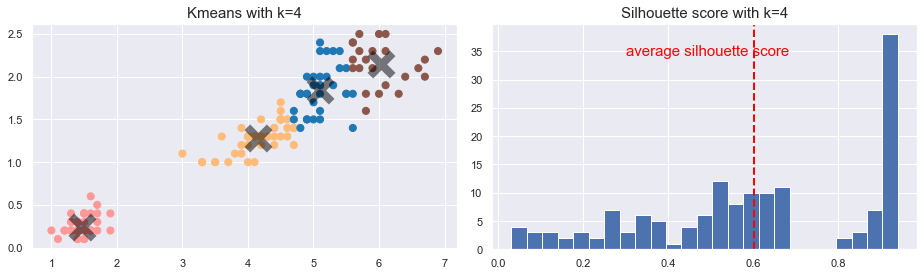

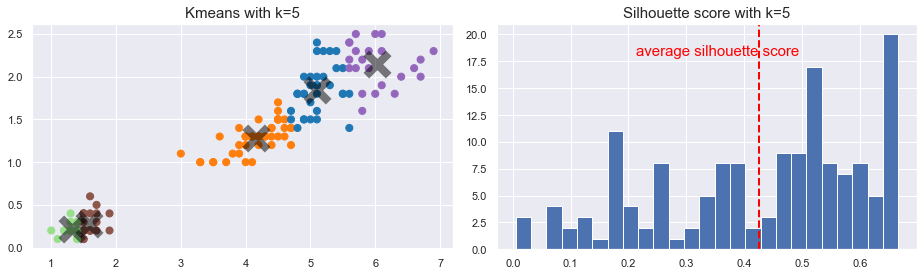

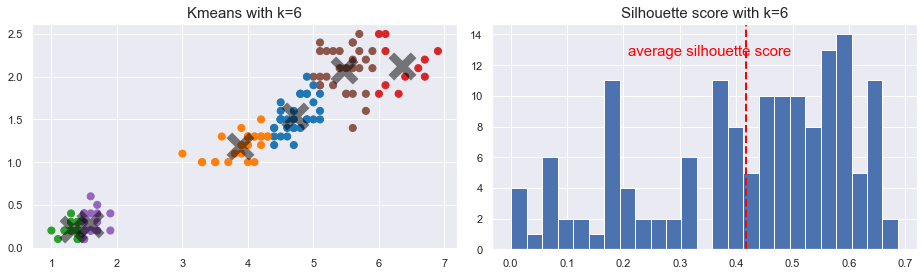

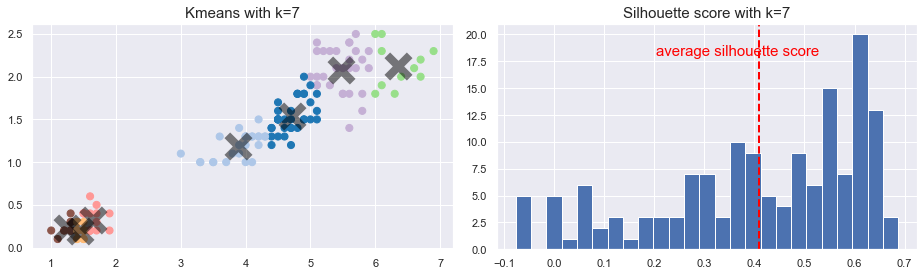

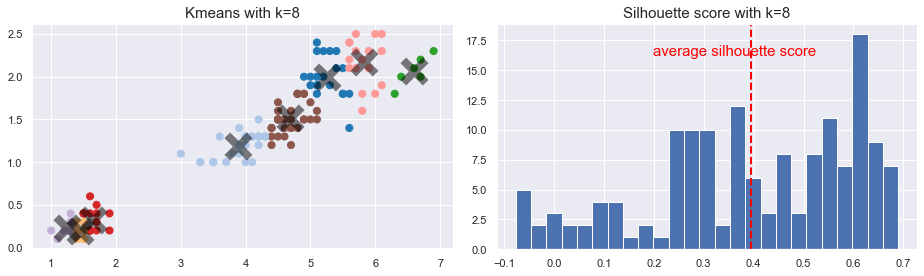

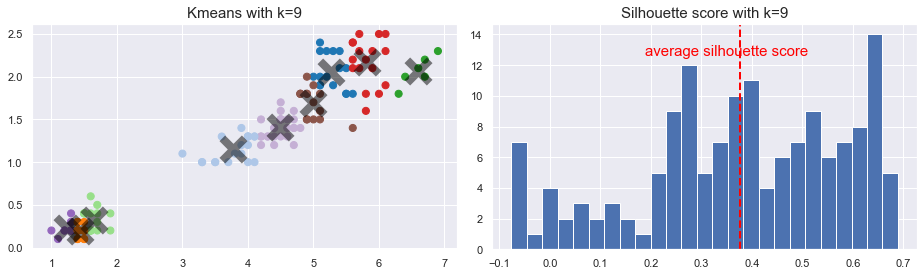

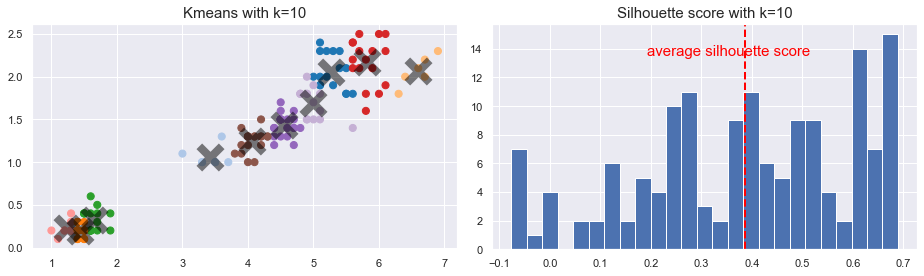

In [9]:
# Import necessary packages
from sklearn.metrics import silhouette_samples, silhouette_score

# Variables definition
random_seed = 0
colors = cmap.get_cmap("tab20")
colors = colors(range(11))
n_clusters = range(2, 11)

# Datasets variables (comment/uncomment at convenience to apply on different data)
X = only_petal_features
# X = dataset.data_pca
# X = dataset.data_lda

# For each cluster
for k in n_clusters:
    # Generate main figure
    fig, ax = plt.subplots(1, 2, figsize=(13, 4))

    # Compute k-means clustering
    centroids, clusters, _ = find_clusters(X, k, rseed=random_seed)

    # Generate clustering plot
    ax[0].scatter(X[:, 0], X[:, 1], c=clusters, s=50, cmap=matplotlib.colors.ListedColormap(colors))
    ax[0].scatter(centroids[:, 0], centroids[:, 1], c="black", marker="x", linewidth=8, alpha=0.5, s=500)
    ax[0].set_title("Kmeans with k=" + str(k), fontsize=15)

    # Compute silhouette score
    samples_silhouette = silhouette_samples(X, clusters)
    score_silhouette = silhouette_score(X, clusters)

    # Plot silhouette score
    vals = ax[1].hist(samples_silhouette, bins=25)[0]
    ax[1].axvline(score_silhouette, color="red", linestyle="--", linewidth=2)
    ax[1].set_title("Silhouette score with k=" + str(k), fontsize=15)
    ax[1].annotate("average silhouette score", (score_silhouette * 0.5, np.max(vals) * 0.9), c="red", fontsize=15)
    
    # Tweak layout (optional)
    plt.tight_layout()

## <u>Assignment</u> How many clusters (2) ?  “knee finding”: sum of the squared distance
* Plot sum of the squared distances of your kmeans implementation
* Plot inertia from [sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

Example of output
![title](images/knee.png)

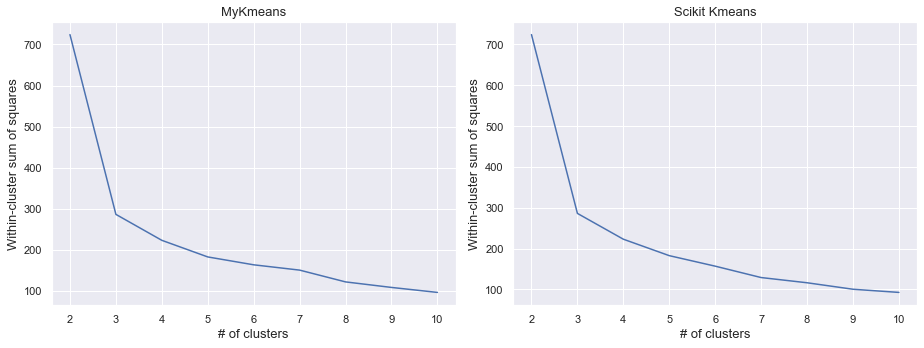

In [10]:
# Import necessary packages
from sklearn.cluster import KMeans

# Variables definition
random_seed = 0
n_clusters = range(2, 11)

# Support data structures
ssd_list = list()
ssd_list_scikit = list()

# Datasets variables (comment/uncomment at convenience to apply on different data)
# X = only_petal_features
# X = dataset.data_pca
X = dataset.data_lda

# For each cluster
for k in n_clusters:
    # Compute custom SSD
    ssd_list.append(find_clusters(X, k, rseed=random_seed)[2])

    # Compute scikit-learn SSD
    ssd_list_scikit.append(KMeans(n_clusters=k).fit(X).inertia_)

# Generate main figure
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ax[0].plot(n_clusters, ssd_list)
ax[1].plot(n_clusters, ssd_list_scikit)

# Plot custom SSD
ax[0].set_title("MyKmeans", fontsize=13)
ax[0].set_xlabel("# of clusters", fontsize=13)
ax[0].set_ylabel("Within-cluster sum of squares", fontsize=13)

# Plot scikit-learn SSD
ax[1].set_title("Scikit Kmeans", fontsize=13)
ax[1].set_xlabel("# of clusters", fontsize=13)
ax[1].set_ylabel("Within-cluster sum of squares", fontsize=13)

# Tweak layout (optional)
plt.tight_layout()

## Comparing different clustering techniques

In [11]:
from sklearn import metrics
from sklearn.cluster import DBSCAN,  MiniBatchKMeans, AgglomerativeClustering

X = only_petal_features
labels_true = dataset.target

kmeans = KMeans(n_clusters=3, n_init=50, random_state=0)
mb_kmeans = MiniBatchKMeans(n_clusters=3,
                            random_state=0,
                            batch_size=10)
dbscan = DBSCAN(eps=.3)
agg = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="ward")
estimators = [("k_means", kmeans), 
              ("dbscan", dbscan),
              ("agglomerative", agg),
              ("mb_kmenas", mb_kmeans)]
for name, est in estimators:
    est.fit(X)
    if name != "gmm":
        labels = est.labels_
    else:
        labels = est.predict(X)

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    print("{}".format(name))
    print("\tEstimated number of clusters: %d" % n_clusters_)
    print("\tEstimated number of noise points: %d" % n_noise_)
    print("\tHomogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
    print("\tCompleteness: %0.3f" % metrics.completeness_score(labels_true, labels))
    print("\tV-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
    print("\tAdjusted Rand Index: %0.3f"
          % metrics.adjusted_rand_score(labels_true, labels))
    print("\tAdjusted Mutual Information: %0.3f"
          % metrics.adjusted_mutual_info_score(labels_true, labels))
    print("\tSilhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X, labels))
    print("\n")

k_means
	Estimated number of clusters: 3
	Estimated number of noise points: 0
	Homogeneity: 0.864
	Completeness: 0.864
	V-measure: 0.864
	Adjusted Rand Index: 0.886
	Adjusted Mutual Information: 0.862
	Silhouette Coefficient: 0.660


dbscan
	Estimated number of clusters: 2
	Estimated number of noise points: 6
	Homogeneity: 0.589
	Completeness: 0.821
	V-measure: 0.686
	Adjusted Rand Index: 0.556
	Adjusted Mutual Information: 0.681
	Silhouette Coefficient: 0.591


agglomerative
	Estimated number of clusters: 3
	Estimated number of noise points: 0
	Homogeneity: 0.870
	Completeness: 0.871
	V-measure: 0.871
	Adjusted Rand Index: 0.886
	Adjusted Mutual Information: 0.869
	Silhouette Coefficient: 0.657


mb_kmenas
	Estimated number of clusters: 3
	Estimated number of noise points: 0
	Homogeneity: 0.901
	Completeness: 0.901
	V-measure: 0.901
	Adjusted Rand Index: 0.922
	Adjusted Mutual Information: 0.900
	Silhouette Coefficient: 0.659




# MNIST dataset

## Different clustering benchmarking
Here we want to focus on the parameter `init` of [sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

    init{‘k-means++’, ‘random’}, callable or array-like of shape (n_clusters, n_features), default=’k-means++’

    Method for initialization:

    ‘k-means++’ : selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. See section Notes in k_init for more details.

    ‘random’: choose n_clusters observations (rows) at random from data for the initial centroids.

    If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.

    If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.


In [12]:
from sklearn.datasets import load_digits
from sklearn.pipeline import make_pipeline

X, y = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = X.shape, np.unique(y).size

# Perform PCA
data_pca = PCA(n_components=10).fit_transform(X)

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# Define the metrics which require only the true labels and estimators labels
clustering_metrics = [
    sklearn.metrics.homogeneity_score,
    sklearn.metrics.completeness_score,
    sklearn.metrics.v_measure_score,
    sklearn.metrics.adjusted_rand_score,
    sklearn.metrics.adjusted_mutual_info_score,
]


pipelines = [
    Pipeline([("clustering", KMeans(init="k-means++", n_clusters=n_digits, random_state=0))]),
    Pipeline([("clustering", KMeans(init=PCA(n_components=10).fit(X).components_, n_init=1, n_clusters=n_digits, random_state=0))]),
    Pipeline([("clustering", KMeans(init="k-means++", n_clusters=n_digits, random_state=0))])
]
names = ["k-means++", "pca_init", "on_pca"]

print(55 * "_")
print("init\t\thomo\tcompl\tv-meas\tARI\tAMI")
for pipeline, name in zip(pipelines, names):
    if name == "on_pca":
        estimator = pipeline.fit(data_pca)
    else:
        estimator = pipeline.fit(X)
    # Show the results
    results = [name]
    results += [m(y, estimator[-1].labels_) for m in clustering_metrics]
    formatter_result = ("{:9s}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))
print(55 * "_")

# digits: 10; # samples: 1797; # features 64
_______________________________________________________
init		homo	compl	v-meas	ARI	AMI
k-means++	0.742	0.751	0.747	0.669	0.744
pca_init 	0.784	0.787	0.785	0.741	0.783
on_pca   	0.722	0.730	0.726	0.649	0.723
_______________________________________________________


## <u>Optional Assignment</u> See cluster centers as images
Example of output
![title](images/mnist.png)

(-34.31344780239751, 34.84362244031734, -30.373785707096975, 32.97159921022566)

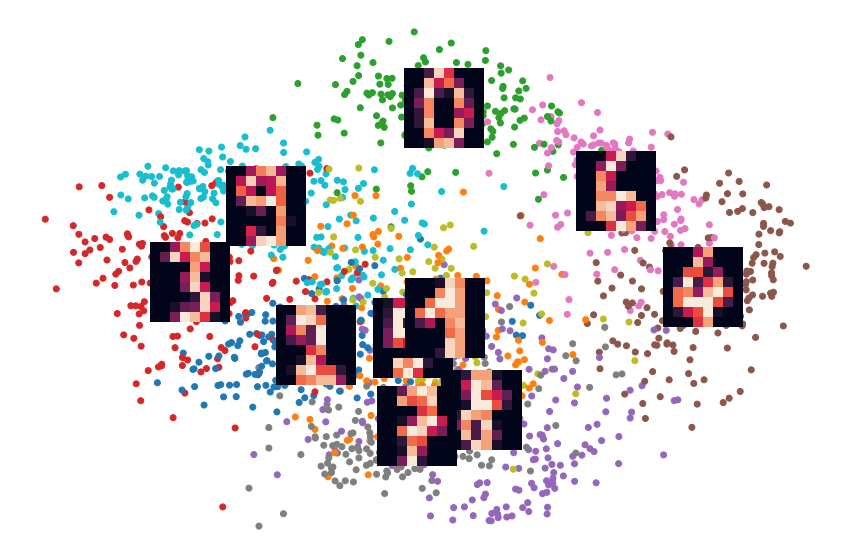

In [13]:
# Import necessary packages
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox  # To plot image in graph. Look docs online
from sklearn.datasets import load_digits

# Load the dataset
X, y = load_digits(return_X_y=True)

# Get number of digits
n_digits = np.unique(y).size

# Perform PCA
pca = PCA(n_components=10).fit_transform(X)

# Compute k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=n_digits)
kmeans.fit(pca)

# Get resulting centroids and clusters
centroids = kmeans.cluster_centers_
clusters = sklearn.metrics.pairwise_distances_argmin_min(centroids, pca)[0]

# Get images
images = X[clusters].reshape((n_digits, 8, 8))

# Generate main figure
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Add points
ax.scatter(pca[:, 0], pca[:, 1], c=kmeans.labels_, cmap="tab10")

# Add images
for c, i in zip(centroids, images):
    ax.add_artist(AnnotationBbox(OffsetImage(i, zoom=10), (c[0], c[1]), frameon=False))

# Remove axes (optional)
ax.axis("off")

# CRC (Colon tissue images)

In [14]:
rootpath = "../data/"
dataset_df = pd.read_csv(os.path.join(rootpath, "crc.csv"))
features_array = np.load("../data/features_A.npy")

## Real distribution

Text(0.5, 1.0, 'Data LDA')

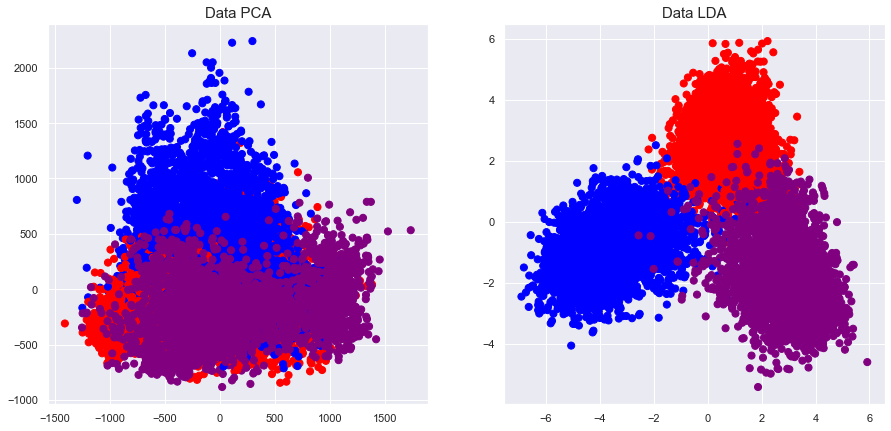

In [15]:
colors = ["red", "green", "blue", "purple"]

# A value of 16 for the PCA allows to get 95% of the explained variance
data_pca = PCA(n_components=16, svd_solver="full").fit_transform(features_array)

data_lda = LinearDiscriminantAnalysis(n_components=2).fit_transform(features_array,
                                                                    dataset_df["Label_3_classes_numerical"])
dataset = Dataset(X,
                  dataset_df["Label_3_classes_numerical"],
                  dataset_df["Label_3_classes"].unique(),
                  data_pca,
                  data_lda)

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].scatter(dataset.data_pca[:, 0], dataset.data_pca[:, 1], c=dataset.target, s=50, cmap=matplotlib.colors.ListedColormap(colors))
ax[0].set_title("Data PCA", fontsize=15)

ax[1].scatter(dataset.data_lda[:, 0], dataset.data_lda[:, 1], c=dataset.target, s=50, cmap=matplotlib.colors.ListedColormap(colors))
ax[1].set_title("Data LDA", fontsize=15)

## <u>Assignment</u> How many clusters (1)? Silhouette scores 
Try PCA and LDA also

(1/16) K=2: Computing Data PCA...
(1/16) Done!
(2/16) K=2: Computing Data LDA...
(2/16) Done!
(3/16) K=3: Computing Data PCA...
(3/16) Done!
(4/16) K=3: Computing Data LDA...
(4/16) Done!
(5/16) K=4: Computing Data PCA...
(5/16) Done!
(6/16) K=4: Computing Data LDA...
(6/16) Done!
(7/16) K=5: Computing Data PCA...
(7/16) Done!
(8/16) K=5: Computing Data LDA...
(8/16) Done!
(9/16) K=6: Computing Data PCA...
(9/16) Done!
(10/16) K=6: Computing Data LDA...
(10/16) Done!
(11/16) K=7: Computing Data PCA...
(11/16) Done!
(12/16) K=7: Computing Data LDA...
(12/16) Done!
(13/16) K=8: Computing Data PCA...
(13/16) Done!
(14/16) K=8: Computing Data LDA...
(14/16) Done!
(15/16) K=9: Computing Data PCA...
(15/16) Done!
(16/16) K=9: Computing Data LDA...
(16/16) Done!


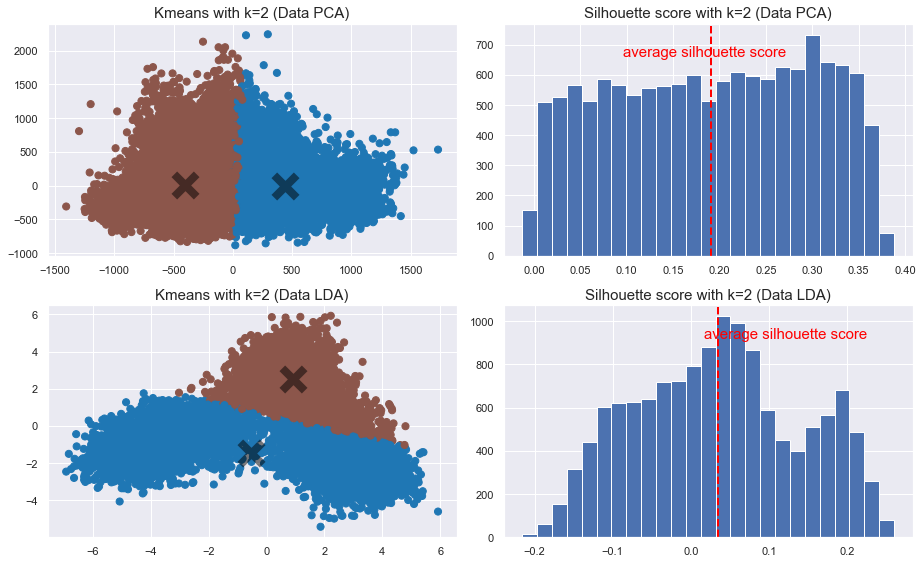

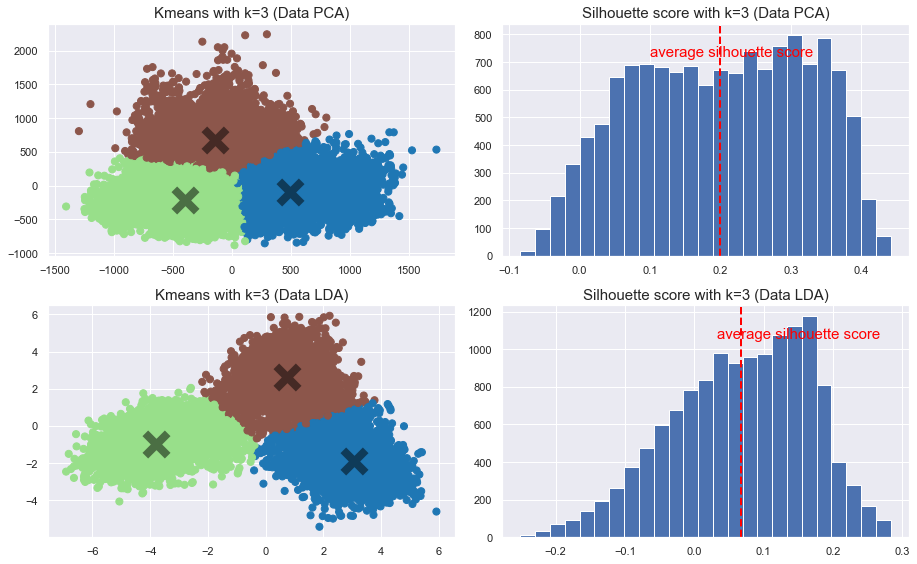

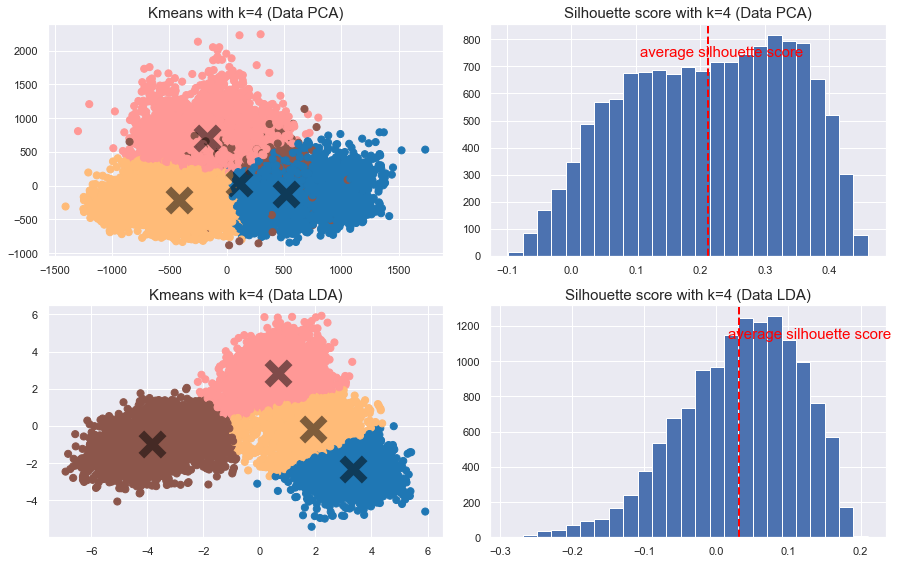

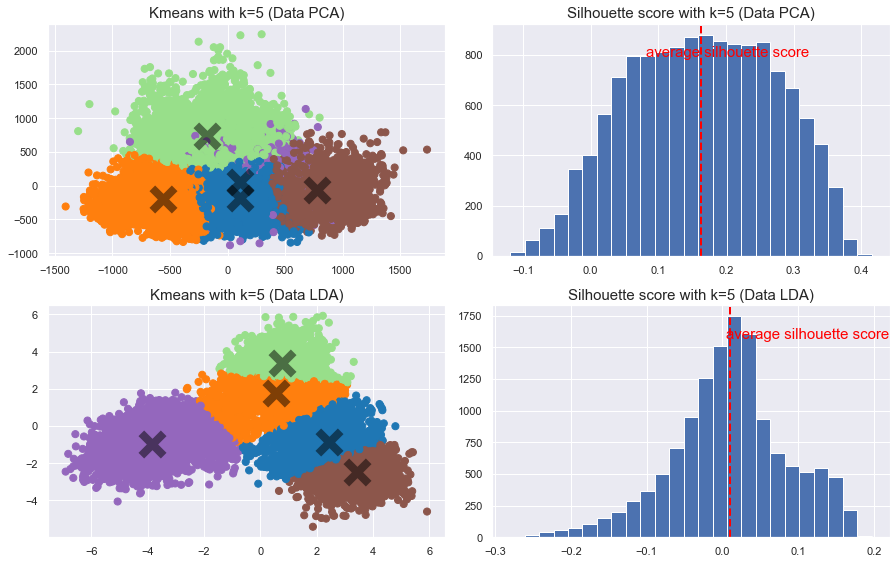

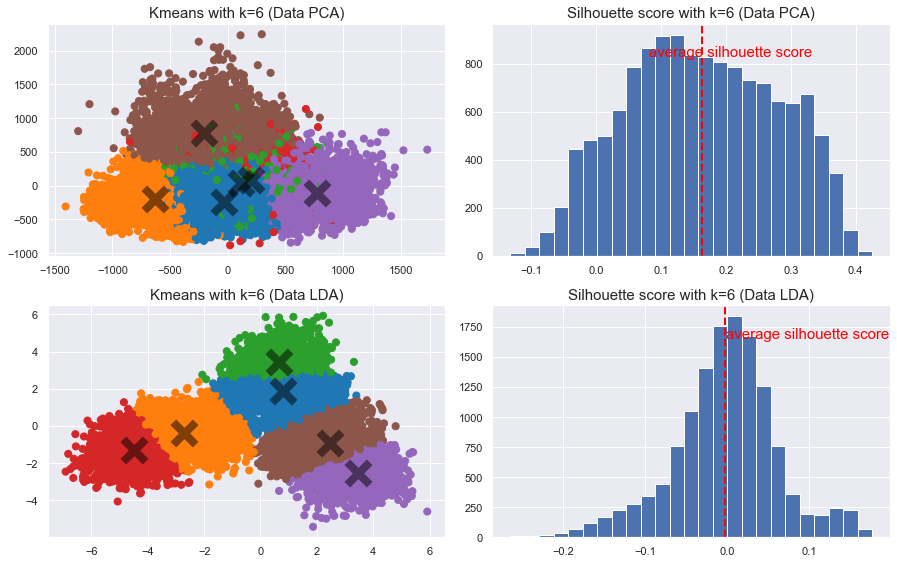

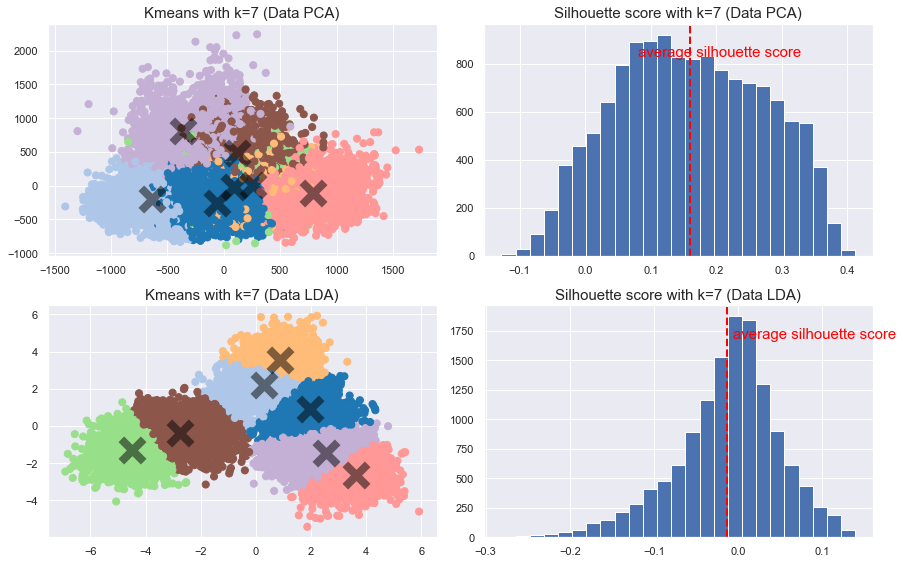

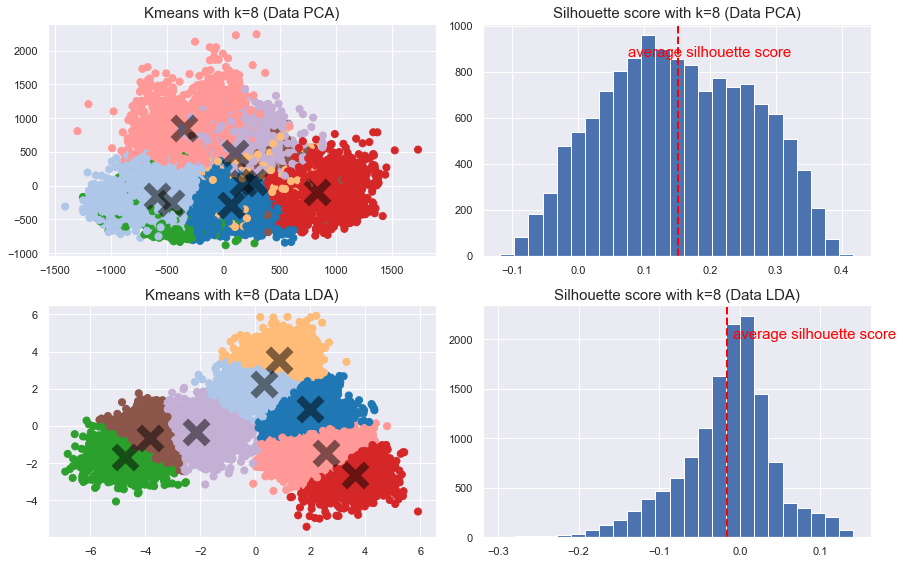

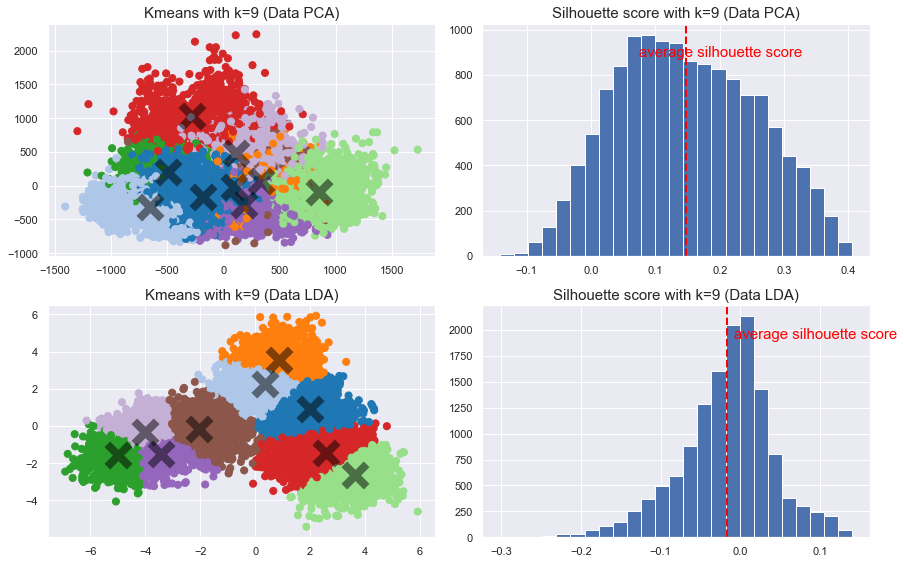

In [16]:
# Attention: this cell can take about a minute and a half to compute!

# Import necessary packages
from sklearn.metrics import silhouette_samples, silhouette_score

# Variables definition
random_seed = 1
colors = cmap.get_cmap("tab20")
colors = colors(range(11))
n_clusters = range(2, 10)
i = 1

# Datasets variables
X = dataset.data_pca
Y = dataset.data_lda

# For each cluster
for k in n_clusters:
    # Generate the main figure
    fig, ax = plt.subplots(2, 2, figsize=(13, 8))

    # ------------------------------ Compute on Data PCA ------------------------------
    print("(" + str(i) + "/" + str(len(n_clusters) * 2) + ") K=" + str(k) + ": Computing Data PCA...")

    # Compute k-means clustering
    centroids_pca, clusters_pca, _ = find_clusters(X, k, rseed=random_seed)

    # Generate clustering plot
    ax[0][0].scatter(X[:, 0], X[:, 1], c=clusters_pca, s=50, cmap=matplotlib.colors.ListedColormap(colors))
    ax[0][0].scatter(centroids_pca[:, 0], centroids_pca[:, 1], c="black", marker="x", linewidth=8, alpha=0.5, s=500)
    ax[0][0].set_title("Kmeans with k=" + str(k) + " (Data PCA)", fontsize=15)

    # Compute silhouette score
    samples_silhouette_pca = silhouette_samples(X, clusters_pca)
    score_silhouette_pca = silhouette_score(X, clusters_pca)

    print("(" + str(i) + "/" + str(len(n_clusters) * 2) + ") Done!")
    i += 1

    # Plot silhouette score
    vals = ax[0][1].hist(samples_silhouette_pca, bins=25)
    ax[0][1].axvline(score_silhouette_pca, color="red", linestyle="--", linewidth=2)
    ax[0][1].set_title("Silhouette score with k=" + str(k) + " (Data PCA)", fontsize=15)
    ax[0][1].annotate("average silhouette score", (score_silhouette_pca * 0.5, np.max(vals[0]) * 0.9), c="red",
                      fontsize=15)

    # ------------------------------ Compute on Data LDA ------------------------------
    print("(" + str(i) + "/" + str(len(n_clusters) * 2) + ") K=" + str(k) + ": Computing Data LDA...")

    # Compute k-means clustering
    centroids_lda, clusters_lda, _ = find_clusters(Y, k, rseed=random_seed)

    # Generate clustering plot
    ax[1][0].scatter(Y[:, 0], Y[:, 1], c=clusters_lda, s=50, cmap=matplotlib.colors.ListedColormap(colors))
    ax[1][0].scatter(centroids_lda[:, 0], centroids_lda[:, 1], c="black", marker="x", linewidth=8, alpha=0.5, s=500)
    ax[1][0].set_title("Kmeans with k=" + str(k) + " (Data LDA)", fontsize=15)

    # Compute silhouette score
    samples_silhouette_lda = silhouette_samples(X, clusters_lda)
    score_silhouette_lda = silhouette_score(X, clusters_lda)

    print("(" + str(i) + "/" + str(len(n_clusters) * 2) + ") Done!")
    i += 1

    # Plot silhouette score
    vals = ax[1][1].hist(samples_silhouette_lda, bins=25)
    ax[1][1].axvline(score_silhouette_lda, color="red", linestyle="--", linewidth=2)
    ax[1][1].set_title("Silhouette score with k=" + str(k) + " (Data LDA)", fontsize=15)
    ax[1][1].annotate("average silhouette score", (score_silhouette_lda * 0.5, np.max(vals[0]) * 0.9), c="red",
                      fontsize=15)

    # Tweak layout (optional)
    plt.tight_layout()

## <u>Assignment</u> How many clusters (2) Silhouette scores

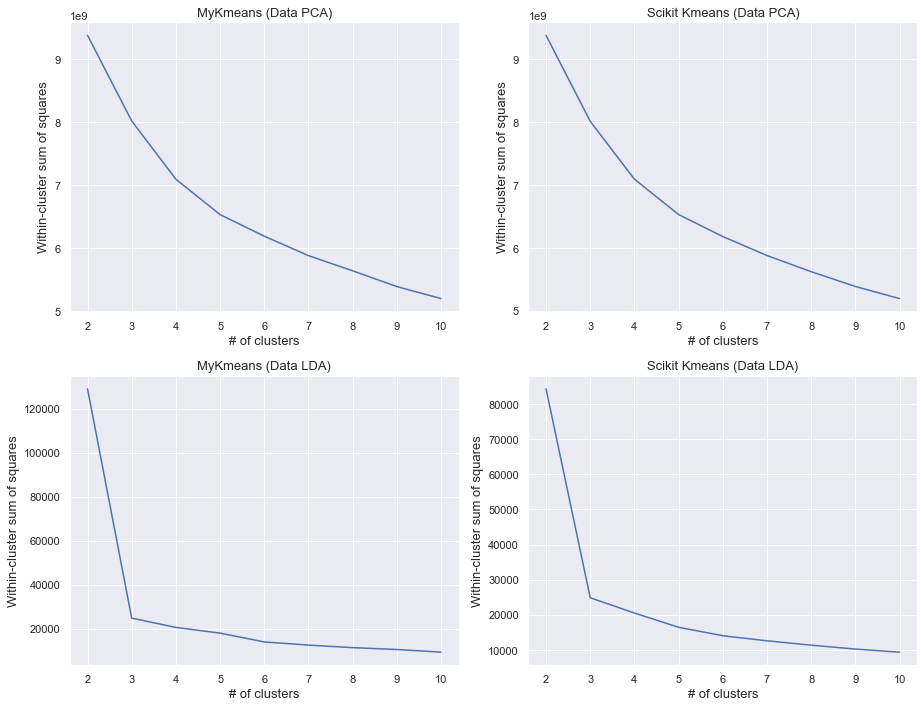

In [17]:
# Variables definition
random_seed = 1
n_clusters = range(2, 11)

# Support data structures
ssd_list_pca = list()
ssd_list_scikit_pca = list()
ssd_list_lda = list()
ssd_list_scikit_lda = list()

# Datasets variables
X = dataset.data_pca
Y = dataset.data_lda

# For each cluster
for k in n_clusters:
    # Compute custom SSD
    ssd_list_pca.append(find_clusters(X, k, rseed=random_seed)[2])
    ssd_list_lda.append(find_clusters(Y, k, rseed=random_seed)[2])

    # Compute scikit-learn SSD
    ssd_list_scikit_pca.append(KMeans(n_clusters=k).fit(X).inertia_)
    ssd_list_scikit_lda.append(KMeans(n_clusters=k).fit(Y).inertia_)

# Generate main figure
fig, ax = plt.subplots(2, 2, figsize=(13, 10))

# Plot Data PCA
ax[0][0].plot(n_clusters, ssd_list_pca)
ax[0][1].plot(n_clusters, ssd_list_scikit_pca)

ax[0][0].set_title("MyKmeans (Data PCA)", fontsize=13)
ax[0][0].set_xlabel("# of clusters", fontsize=13)
ax[0][0].set_ylabel("Within-cluster sum of squares", fontsize=13)

ax[0][1].set_title("Scikit Kmeans (Data PCA)", fontsize=13)
ax[0][1].set_xlabel("# of clusters", fontsize=13)
ax[0][1].set_ylabel("Within-cluster sum of squares", fontsize=13)

# Plot Data LDA
ax[1][0].plot(n_clusters, ssd_list_lda)
ax[1][1].plot(n_clusters, ssd_list_scikit_lda)

ax[1][0].set_title("MyKmeans (Data LDA)", fontsize=13)
ax[1][0].set_xlabel("# of clusters", fontsize=13)
ax[1][0].set_ylabel("Within-cluster sum of squares", fontsize=13)

ax[1][1].set_title("Scikit Kmeans (Data LDA)", fontsize=13)
ax[1][1].set_xlabel("# of clusters", fontsize=13)
ax[1][1].set_ylabel("Within-cluster sum of squares", fontsize=13)

# Tweak layout (optional)
plt.tight_layout()